In [2]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
import yaml
import re

import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

stat_path="../stat_to_sankey/example_stat/1p9f9s_run"
iamge_path=f"{stat_path}/images"


In [3]:
import os
import re

def search_files_with_name(directory, pattern):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if re.search(pattern, file):
                file_list.append(os.path.join(root, file))
                #print(os.path.join(root, file))
    return file_list



def display_all_nodes_attr(G):
    for node in G.nodes():
        print(f"Node Name: {node}")
        print(f"- Order: {G.nodes[node]['order']} - Type: {G.nodes[node]['type']} - Position: {G.nodes[node]['pos']}")
        # print(f"- Statistics: {G.nodes[node]['stat']}")
    
def add_file_nodes(G, stat_dict):
    stat_file = list(stat_dict.keys())[0]
    # print(stat_file)
    for li in vfd_dict[stat_file]:
        k = list(li.keys())[0]
        if 'file' in k:
            parts = k.split("-")
            node_name = f"{k} : {li[k]['file_name']}"
            node_order = int(parts[1])
            node_attrs = {node_name: {'order': node_order, 'type':'file', 'stat':li[k]}}
            G.add_node(node_name, pos=(0,node_order))
            nx.set_node_attributes(G, node_attrs)

# Read in task_to_file mapping yaml file
def load_task_file_map():
    task_file_map = {}
    with open(f"{stat_path}/task_to_file.yaml", "r") as stream:
        try:
            task_file_map = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return task_file_map

task_file_map = load_task_file_map()

def add_task_nodes(G, tfe_dic):
    skip_pos = 2
    task_pos = 1
    # task_file_edges dictionay
    for task_name,v in tfe_dic.items():
        task_order = v['order']
        node_attrs = {task_name: {'order': task_order, 'type':'task', 'stat':v}}
        G.add_node(task_name, pos=(task_pos,0))
        nx.set_node_attributes(G, node_attrs)
        task_pos += skip_pos



In [15]:
def get_file_nodes_names_in_order(G):
    file_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'file']
    data = []
    for n in file_nodes:
        order = G.nodes[n]['order']
        file_name = G.nodes[n]['stat']['file_name']
        data.append((order, file_name, n))
    return sorted(data, key=lambda x: x[0]) #everse=True

def remove_duplicate_file_nodes(G, keep_nodes):
    file_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'file']
    for n in file_nodes:
        if n not in keep_nodes:
            G.remove_node(n)

def add_task_file_edges(G, map_dic):
    file_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'file']
    file_node_rsorted = get_file_nodes_names_in_order(G)
    actual_file_nodes = []
    edge_list = []
    for task_name, v in map_dic.items():
        for file_name in v['input']:
            for i, triplet in enumerate(file_node_rsorted):
                if file_name == triplet[1]:
                    edge_list.append((triplet[2], task_name))
                    actual_file_nodes.append(triplet[2])
                    # file_node_rsorted.pop(i)
                    # update file node position
                    G.nodes[triplet[2]]['pos'] = (G.nodes[task_name]['pos'][0] - 1, G.nodes[triplet[2]]['pos'][1])
                    break

        for file_name in v['output']:
            for i, triplet in enumerate(file_node_rsorted):
                if file_name == triplet[1]:
                    edge_list.append((task_name, triplet[2]))
                    actual_file_nodes.append(triplet[2])
                    # file_node_rsorted.pop(i)
                    # update file node position
                    G.nodes[triplet[2]]['pos'] = (G.nodes[task_name]['pos'][0] + 1, G.nodes[triplet[2]]['pos'][1])
                    break

    for e in edge_list:
        print(e)
    remove_duplicate_file_nodes(G, actual_file_nodes)
    G.add_edges_from(edge_list)
    return G

# TODO
- fix VFD output format with `metadata:` before memtype list


In [16]:
vfd_files = search_files_with_name(stat_path, "vfd")
vfd_files = vfd_files[0:1]
print(vfd_files)

def load_vfd_yaml(vfd_files):
    ret_dict = {}
    tmp_dict = {}
    for f in vfd_files:
        with open(f, "r") as stream:
            print(f"loading {f}")
            try:
                tmp_dict = yaml.safe_load(stream)
                print(tmp_dict)
            except yaml.YAMLError as exc:
                print(exc)
            ret_dict[f] = tmp_dict
    return ret_dict

vfd_dict = load_vfd_yaml(vfd_files)
# print(vfd_dict)



['../stat_to_sankey/example_stat/1p9f9s_run/5904_vfd-data-stat-dl.yaml']
loading ../stat_to_sankey/example_stat/1p9f9s_run/5904_vfd-data-stat-dl.yaml
[{'file-1': {'file_name': 'cloudid_20150506_050000.nc', 'open_time': 1686711069705514, 'close_time': 0, 'file_intent': [], 'file_no': 0, 'file_read_cnt': 129, 'file_write_cnt': 0, 'file_size': 7118442, 'ata': [{'H5FD_MEM_DRAW': {'read_bytes': 58718, 'read_cnt': 7, 'read_ranges': {'122:(0': None, '0)': None, '123:(6': None, '6)': None, '124:(6': None, '125:(6': None, '126:(6': None, '381:(4': None, '4)': None, '511:(4': None}, 'write_bytes': 0, 'write_cnt': 0, 'write_ranges': {}}}], 'metadata': [{'H5FD_MEM_OHDR': {'read_bytes': 21373, 'read_cnt': 84, 'read_ranges': {'3:(0': None, '0)': None, '4:(0': None, '6:(0': None, '8:(4': None, '4)': None, '11:(0': None, '12:(6': None, '6)': None, '14:(0': None, '15:(0': None, '16:(6': None, '18:(1': None, '1)': None, '19:(1': None, '20:(6': None, '22:(1': None, '23:(1': None, '24:(6': None, '26:(4': 

In [18]:
G_VFD = nx.DiGraph()

add_file_nodes(G_VFD, vfd_dict)
print(task_file_map)
add_task_nodes(G_VFD, task_file_map)

display_all_nodes_attr(G_VFD)


{'run_idfeature': {'order': 0, 'task_pid': 75190, 'op_count_range': [5, 5], 'input': ['wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_02:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_03:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_04:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_05:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_06:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_07:00:00.nc', 'wrfout_rainrate_tb_zh_mh_2015-05-06_08:00:00.nc'], 'output': ['cloudid_20150506_040000.nc', 'cloudid_20150506_000000.nc', 'cloudid_20150506_010000.nc', 'cloudid_20150506_020000.nc', 'cloudid_20150506_030000.nc', 'cloudid_20150506_040000.nc', 'cloudid_20150506_050000.nc', 'cloudid_20150506_060000.nc', 'cloudid_20150506_070000.nc', 'cloudid_20150506_080000.nc']}, 'run_tracksingle': {'order': 1, 'task_pid': 5904, 'op_count_range': [5, 5], 'input': ['cloudid_20150506_000000.nc', 'cloudid_20150506_010000.

In [19]:




G_VFD = add_task_file_edges(G_VFD, task_file_map)
display_all_nodes_attr(G_VFD)

    

('run_idfeature', 'file-2 : cloudid_20150506_040000.nc')
('run_idfeature', 'file-23 : cloudid_20150506_000000.nc')
('run_idfeature', 'file-4 : cloudid_20150506_010000.nc')
('run_idfeature', 'file-8 : cloudid_20150506_020000.nc')
('run_idfeature', 'file-3 : cloudid_20150506_030000.nc')
('run_idfeature', 'file-2 : cloudid_20150506_040000.nc')
('run_idfeature', 'file-1 : cloudid_20150506_050000.nc')
('run_idfeature', 'file-5 : cloudid_20150506_060000.nc')
('run_idfeature', 'file-19 : cloudid_20150506_070000.nc')
('run_idfeature', 'file-24 : cloudid_20150506_080000.nc')
('file-23 : cloudid_20150506_000000.nc', 'run_tracksingle')
('file-4 : cloudid_20150506_010000.nc', 'run_tracksingle')
('file-8 : cloudid_20150506_020000.nc', 'run_tracksingle')
('file-3 : cloudid_20150506_030000.nc', 'run_tracksingle')
('file-2 : cloudid_20150506_040000.nc', 'run_tracksingle')
('file-1 : cloudid_20150506_050000.nc', 'run_tracksingle')
('file-5 : cloudid_20150506_060000.nc', 'run_tracksingle')
('file-19 : c

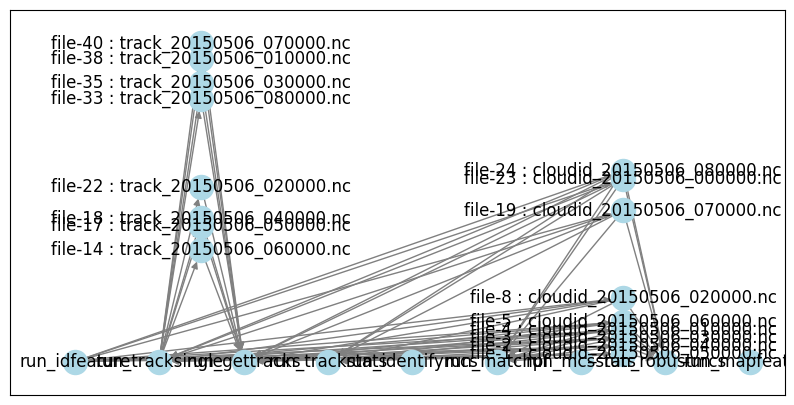

In [20]:
def draw_graph(G):
    plt.figure(figsize=(10, 5))
    pos = {node: data['pos'] for node, data in G.nodes(data=True)}
    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')

    # Show the graph
    plt.show()
draw_graph(G_VFD)

In [284]:
# Add to network x